# **Algorithm 1**

Files already downloaded and verified
Files already downloaded and verified
Scenario Complexity (Beta): 0.8662936091423035


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Channel Importance Scores Computed


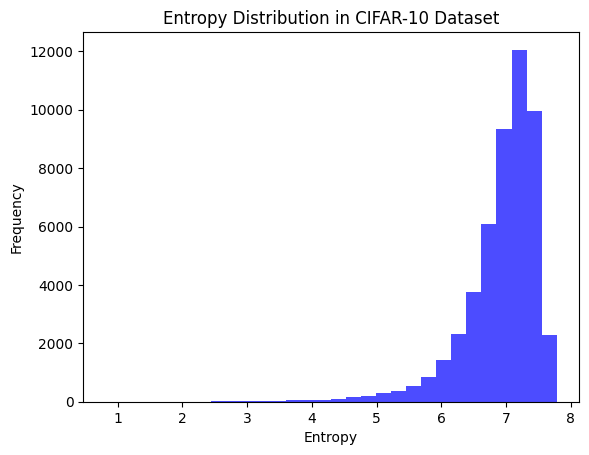

In [22]:
import os
import cv2
import numpy as np
import torch
import torchvision.models as models
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors
])

# Load CIFAR-10 dataset
def load_cifar10(data_path):
    train_dataset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Compute Scenario Complexity using Pixel Entropy
def compute_scenario_complexity(dataset):
    entropy_values = []
    for img, _ in dataset:
        img = torch.mean(img, dim=0).numpy() * 255  # Convert to grayscale
        hist = cv2.calcHist([img.astype(np.uint8)], [0], None, [256], [0, 256])
        hist = hist / np.sum(hist)  # Normalize histogram
        entropy = -np.sum(hist * np.log2(hist + 1e-10))  # Compute entropy
        entropy_values.append(entropy)

    beta = np.mean(entropy_values) / np.log2(256)  # Normalize to [0,1]
    return beta, entropy_values

# Compute Channel Importance
def compute_channel_importance(model, dataloader, beta, T=1):
    importance_scores = {}
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            X = batch[0].to(next(model.parameters()).device)
            if X.shape[1] == 1:
                X = X.repeat(1, 3, 1, 1)  # Convert grayscale to RGB

            for name, layer in model.named_modules():
                if isinstance(layer, torch.nn.Conv2d):
                    try:
                        if X.shape[1] != layer.weight.shape[1]:
                            continue
                        X = layer(X)

                        # Compute importance
                        mean_per_channel = torch.mean(X, dim=0, keepdim=True)
                        dynamic_importance = torch.mean((X - mean_per_channel) ** 2, dim=[0, 2, 3])
                        static_importance = torch.norm(layer.weight, p=1, dim=[1, 2, 3])
                        alpha = (beta ** 0.5) / T
                        channel_importance = (1 - alpha) * dynamic_importance + alpha * static_importance

                        importance_scores[name] = channel_importance.cpu().numpy()
                    except Exception as e:
                        print(f"Error processing layer {name}: {e}")
            break  # Process one batch for efficiency

    return importance_scores

# Load dataset
data_path = "./cifar10_data"
train_dataset, test_dataset = load_cifar10(data_path)

# Create data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)  # ✅ Added for evaluation

# Compute scenario complexity
beta, entropy_values = compute_scenario_complexity(train_dataset)
print(f"Scenario Complexity (Beta): {beta}")

# Load pre-trained SSD-VGG model
model = models.detection.ssd300_vgg16(pretrained=True)

# Compute channel importance using **test dataloader**
importance_scores = compute_channel_importance(model, test_dataloader, beta, T=1)  # ✅ Uses test data
print("Channel Importance Scores Computed")

# Visualize entropy distribution
plt.hist(entropy_values, bins=30, color='blue', alpha=0.7)
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.title("Entropy Distribution in CIFAR-10 Dataset")
plt.show()


In [2]:
# Load only 5 samples for debugging
small_dataset = torch.utils.data.Subset(dataset, range(2))
small_dataloader = torch.utils.data.DataLoader(small_dataset, batch_size=1, shuffle=False)

In [3]:
small_importance_scores = compute_channel_importance(model, small_dataloader, beta, T=1)

Layer: backbone.features.0, Channel Importance: [6.955693  3.0487685 2.3222566 6.35076   4.6440716 4.2836943 3.1135821
 3.7741716 4.8957515 3.0291765 7.2288127 3.329373  5.718876  2.9637375
 5.2181816 3.6864438 2.9834185 2.8544497 4.009539  3.392775  4.3215656
 5.0850625 2.8925276 5.366357  1.505572  3.4248714 6.0887284 3.0954971
 5.4188056 3.1895573 3.876362  2.8271956 1.698621  3.0436163 5.8824897
 5.52206   2.5829298 6.243795  3.162048  2.5443115 2.2626975 6.028619
 3.608874  5.086574  2.9769177 8.0482025 3.543008  6.525727  4.5260086
 4.9901104 2.5687962 7.320328  2.4676366 4.2029457 4.5307765 2.639919
 3.0731094 4.820191  5.925259  4.283282  5.3123016 2.7409127 6.8774323
 5.2943306]
Layer: backbone.features.2, Channel Importance: [20.466906  12.840576  13.6496935 14.05227   14.129964  19.780476
 16.418573  10.41596   13.682192   8.984833  20.131191  11.86918
 18.874746  21.474947   6.9331694 13.67511   13.549175  18.233335
 20.859634  22.289572  20.090181  12.629763   8.436704   7

**A layer in your model** → E.g., backbone.features.0

**Importance scores for each channel in that layer** → E.g., [6.955693, 3.0487685, 2.3222566, ...]

**Higher importance values** → Channels that contribute more to feature extraction.

**Lower importance values** → Channels that may be less significant and could be pruned.

In [4]:
for layer, scores in importance_scores.items():
    print(f"Layer: {layer}, Min Importance: {np.min(scores):.4f}, Max Importance: {np.max(scores):.4f}")


Layer: backbone.features.0, Min Importance: 1.5060, Max Importance: 8.0641
Layer: backbone.features.2, Min Importance: 6.9783, Max Importance: 23.0242
Layer: backbone.features.5, Min Importance: 4.4219, Max Importance: 23.8352
Layer: backbone.features.7, Min Importance: 13.9452, Max Importance: 150.5465
Layer: backbone.features.10, Min Importance: 12.1955, Max Importance: 483.0923
Layer: backbone.features.12, Min Importance: 27.2105, Max Importance: 1648.9426
Layer: backbone.features.14, Min Importance: 41.8643, Max Importance: 8731.9932
Layer: backbone.features.17, Min Importance: 45.4501, Max Importance: 11761.2686
Layer: backbone.features.19, Min Importance: 155.2118, Max Importance: 29862.6445
Layer: backbone.features.21, Min Importance: 513.5262, Max Importance: 101972.2656
Layer: backbone.extra.0.1, Min Importance: 3280.5598, Max Importance: 349468.0312
Layer: backbone.extra.0.3, Min Importance: 13316.2988, Max Importance: 3390896.7500
Layer: backbone.extra.0.5, Min Importance: 1

It can be assumed:
*   Pruning should be more aggressive in features.0, features.2, and features.5
*   Less pruning in backbone.features.12,14,17,19,21 extract strong object features.
*  Backbone.extra: Minimal pruning here. Detect objects at multiple scales. Very high max values, layers are critical.
*   No pruning in head.classification_head.module_list.3, as it directly affects classification accuracy.





# **Structured table (DataFrame) of channel importance scores**

In [5]:
import pandas as pd
import numpy as np

# Check if importance_scores exists
if 'importance_scores' in globals() and isinstance(importance_scores, dict) and len(importance_scores) > 0:
    # Flatten scores and store with corresponding layers
    data = []
    for layer, scores in importance_scores.items():
        for i, score in enumerate(scores):
            data.append([layer, i, score])  # Store (Layer Name, Channel Index, Importance Score)

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Layer", "Channel Index", "Importance Score"])

    # Sort by Importance Score
    df_sorted = df.sort_values(by="Importance Score", ascending=True)

    # Print lowest 5 importance scores
    print("=" * 40)
    print("🔹 LOWEST 5 IMPORTANCE SCORES 🔹")
    print("=" * 40)
    print(df_sorted.head(5).to_string(index=False))

    # Print highest 5 importance scores
    print("\n" + "=" * 40)
    print("🔹 HIGHEST 5 IMPORTANCE SCORES 🔹")
    print("=" * 40)
    print(df_sorted.tail(5).to_string(index=False))

else:
    print("Error: `importance_scores` is not defined or empty. Please run Algorithm 1 first.")


🔹 LOWEST 5 IMPORTANCE SCORES 🔹
              Layer  Channel Index  Importance Score
backbone.features.0             24          1.506048
backbone.features.0             32          1.701681
backbone.features.0             40          2.263218
backbone.features.0              2          2.324010
backbone.features.0             52          2.468707

🔹 HIGHEST 5 IMPORTANCE SCORES 🔹
             Layer  Channel Index  Importance Score
backbone.extra.4.2             82      4.203724e+10
backbone.extra.4.2            199      4.247995e+10
backbone.extra.4.2            118      4.933298e+10
backbone.extra.4.2             52      5.167216e+10
backbone.extra.4.2             66      6.133110e+10


In [6]:
# Define a threshold for low-importance channels (adjust if needed)
threshold = 3.0  #Importance Score < 3.0 is considered low importance

# Count low-importance channels per layer
layer_counts = df_sorted[df_sorted["Importance Score"] < threshold].groupby("Layer")["Channel Index"].count() #Keeps only channels that have an importance score lower than 3.0

# Display results
print(layer_counts)


Layer
backbone.features.0    16
Name: Channel Index, dtype: int64


*   Only backbone.features.0 has low-importance channels (with Importance Score < 3.0)

*   A total of 16 channels in this layer are weak and could be potential pruning candidates

*   No other layers have low-importance channels under the current threshold (3.0)

In [7]:
threshold = 5.0  # Increase threshold to find more low-importance channels
layer_counts = df_sorted[df_sorted["Importance Score"] < threshold].groupby("Layer")["Channel Index"].count()
print(layer_counts)


Layer
backbone.features.0    43
backbone.features.5     1
Name: Channel Index, dtype: int64


*   Only backbone.features.0 and backbone.features.5  has low-importance channels (with Importance Score < 5.0)

# **Algorithm 2**

*   Grouping channels based on importance scores
*   Computing the cost of keeping or pruning each group (FLOPs & Params)
*   Preparing importance values for the knapsack solver (Algorithm 3)








In [8]:
import numpy as np

def knapsack_initialize(model, channel_importance, beta, k=0.5, b=0.1, num_groups=3):
    """
    Initializes the knapsack problem by grouping channels and calculating values/constraints.

    Parameters:
    - model: The pre-trained model.
    - channel_importance: Dictionary of channel importance scores per layer.
    - beta: Scenario complexity value (0 to 1).
    - k: Controls sparsity (higher -> preserves more channels).
    - b: Minimum fraction of channels to keep.
    - num_groups: Number of groups to aggregate channels.

    Returns:
    - values (v): Importance values for each group.
    - weights_F (wF): FLOPs cost per group.
    - weights_P (wP): Parameters cost per group.
    """

    values, weights_F, weights_P = [], [], []     #weights_F → Stores FLOPs cost per group. weights_P → Stores parameter count per group.
    total_items = 0  # Initialize t

    for layer_name, importance_scores in channel_importance.items():
        num_channels = len(importance_scores)

        # Compute lower bound of channels to keep
        eta = k * (1 - (1 - beta) * np.sqrt(len(values) / len(channel_importance))) + b  #determine how many channels must be preserved
        num_preserved = min(int(num_channels * eta), num_channels)  # Ensure valid range

        # Sort channels by importance (descending order)
        sorted_indices = np.argsort(-importance_scores)  #Sorted from most important to least important

        # Select channels to prune & preserve
        pruned_channels = sorted_indices[num_preserved:]   #Keeps the top num_preserved channels and marks the rest for pruning

        # Group channels for efficient pruning
        grouped_pruned_channels = np.array_split(pruned_channels, num_groups)

        # Get layer from model
        layer = dict(model.named_modules()).get(layer_name, None)
        if layer is None or not hasattr(layer, "weight"):
            continue  # Skip if layer is not found or has no weights

        for group in grouped_pruned_channels:
            if len(group) == 0:
                continue  # Skip empty groups

            # Compute importance, FLOPs, and Params for the group
            group_importance = sum(importance_scores[i] for i in group)
            group_FLOPs = sum(layer.weight.view(-1)[i].numel() for i in group)  # Corrected access
            group_Params = sum(layer.weight.view(-1)[i].numel() for i in group)  # Corrected access

            values.append(group_importance)
            weights_F.append(group_FLOPs)
            weights_P.append(group_Params)

            total_items += 1  # Increment t

    return values, weights_F, weights_P  # Return after processing all layers


In [9]:
values, weights_F, weights_P = knapsack_initialize(model, importance_scores, beta)

print("Values (Importance Scores per Group of channels):", values)
print("Weights (FLOPs per Group):", weights_F)
print("Weights (Params per Group):", weights_P)


Values (Importance Scores per Group of channels): [28.469270944595337, 25.969562292099, 17.970082640647888, 137.91753101348877, 106.73486804962158, 79.29806184768677, 246.0164556503296, 200.88183879852295, 137.8762845993042, 475.997013092041, 409.4109344482422, 329.2639980316162, 795.8137302398682, 716.9345188140869, 634.49573802948, 1875.8890266418457, 1573.1683464050293, 1284.4642658233643, 5917.722557067871, 3915.806312561035, 2592.196704864502, 35572.9274597168, 23729.98471069336, 13050.783966064453, 126106.24743652344, 84675.94262695312, 46889.04325866699, 595721.2578125, 374117.2048339844, 175674.7889404297, 2915488.931640625, 1973982.849609375, 828952.2683105469, 16861097.609375, 10152533.8046875, 4231944.27734375, 81014754.625, 39934734.78125, 13484132.23828125, 127090898.8125, 71407178.78125, 26754324.297851562, 73486166.9375, 38336088.734375, 10673655.149902344, 60827949.0, 34514347.0, 11135156.3984375, 528969168.0, 265049778.5, 82380074.76623535, 391805340.0, 189590952.5, 35

*   The smallest importance score is 9.91, while the largest exceeds 167.67M

*   FLOPs(determine computational cost) and Parameter costs are identical (common in CNNs), low FLOPs (2-3) → Less computational cost.


*   High FLOPs contribute significantly to model performance (33,34,15 etc)




# **Algorithm 3**

 *  Selects the best channel groups to keep based on their importance, FLOPs, and parameter constraints

In [10]:
import numpy as np

def knapsack_solver(values, weights_F, weights_P, R_F, R_P):
    """
    Solves the multi-constraint knapsack problem to select optimal groups of channels.

    Parameters:
    - values (v): Importance values for each group.
    - weights_F (wF): FLOPs cost per group.
    - weights_P (wP): Parameters cost per group.
    - R_F: FLOPs pruning constraint (fraction of FLOPs to keep).
    - R_P: Parameter pruning constraint (fraction of Params to keep).

    Returns:
    - selected_indices: Indices of the selected channel groups.
    """

    # Number of items (groups)
    t = len(values)

    # Compute FLOPs and Parameter constraints, Computes how many FLOPs & Params can be removed, based on initial ratios we provide
    C_F = int((1 - R_F) * sum(weights_F))  # Target FLOPs limit
    C_P = int((1 - R_P) * sum(weights_P))  # Target Parameter limit

    # Initialize DP table, Dynamic Programming (DP) to find the optimal selection
    A = np.zeros((t + 1, C_F + 1, C_P + 1))

    # Fill DP table (Knapsack Logic)
    for i in range(1, t + 1): #Iterates over all groups (t), FLOPs (C_F), and Params (C_P)
        for c_F in range(C_F + 1):
            for c_P in range(C_P + 1):
                if weights_F[i-1] > c_F or weights_P[i-1] > c_P:
                    A[i, c_F, c_P] = A[i-1, c_F, c_P]  # Cannot include this group, if a group exceeds the FLOP or Param limit, it is skipped
                else:
                    A[i, c_F, c_P] = max(A[i-1, c_F, c_P],
                                         values[i-1] + A[i-1, c_F - weights_F[i-1], c_P - weights_P[i-1]])

    # Backtrack to find selected groups
    selected_indices = []
    i, c_F, c_P = t, C_F, C_P

    while i > 0 and c_F > 0 and c_P > 0:
        if A[i, c_F, c_P] != A[i-1, c_F, c_P]:
            selected_indices.append(i-1)
            c_F -= weights_F[i-1]
            c_P -= weights_P[i-1]
        i -= 1

    return selected_indices


In [11]:
# Define pruning constraints (adjust as needed)
R_F = 0.1  # Keep 30% of FLOPs
R_P = 0.1  # Keep 30% of Params

# Run the knapsack solver with previously computed values
selected_channels = knapsack_solver(values, weights_F, weights_P, R_F, R_P)

# Print selected groups
print(" Selected channels (Indices):", selected_channels)

# Print selected groups with their importance, FLOPs, and Params
print("\Selected Groups Details:")
for idx in selected_channels:
    print(f"channel {idx}: Importance = {values[idx]}, FLOPs = {weights_F[idx]}, Params = {weights_P[idx]}")


 Selected channels (Indices): [71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 19, 18, 3]
\Selected Groups Details:
channel 71: Importance = 1113744729.375, FLOPs = 93, Params = 93
channel 70: Importance = 6300554376.0, FLOPs = 94, Params = 94
channel 69: Importance = 18289677072.0, FLOPs = 94, Params = 94
channel 68: Importance = 272168999.75, FLOPs = 43, Params = 43
channel 67: Importance = 9796027128.0, FLOPs = 44, Params = 44
channel 66: Importance = 44944534848.0, FLOPs = 44, Params = 44
channel 65: Importance = 317057390.96875, FLOPs = 22, Params = 22
channel 64: Importance = 2801290968.0, FLOPs = 22, Params = 22
channel 63: Importance = 8685591328.0, FLOPs = 22, Params = 22
channel 62: Importance = 791216431.9414062, FLOPs = 43, Params = 43
channel 61: Importance = 4542085136.0, FLOPs = 43, Params = 43
channel 60: Importance 

# **Pruning the model**

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

def prune_ssd_vgg16(original_model, selected_channels_per_layer):
    """
    Prunes SSD-VGG16 by removing unselected channels and ensuring input-output consistency.
    """
    pruned_backbone = nn.Sequential()
    prev_out_channels = None

    for name, layer in original_model.backbone.named_children():
        if isinstance(layer, nn.Conv2d) and name in selected_channels_per_layer:
            selected = selected_channels_per_layer[name]

            if len(selected) == 0:
                print(f" Warning: No channels left in {name}. Keeping at least 1.")
                selected = [0]  # Keep at least 1 channel

            # Prune Weights & Bias
            new_weights = layer.weight[selected, :, :, :].clone().detach()
            new_bias = layer.bias[selected].clone().detach() if layer.bias is not None else None

            # Set Input Channels from Previous Layer
            in_channels = prev_out_channels if prev_out_channels is not None else layer.in_channels
            selected_in_channels = list(range(in_channels))  # Keep all input channels

            # Create Pruned Conv2D Layer
            pruned_layer = nn.Conv2d(
                in_channels=len(selected_in_channels),
                out_channels=len(selected),
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
                bias=(layer.bias is not None)
            )

            # Assign Pruned Weights & Bias
            pruned_layer.weight = nn.Parameter(new_weights)
            if new_bias is not None:
                pruned_layer.bias = nn.Parameter(new_bias)

            # Add to Pruned Backbone
            pruned_backbone.add_module(name, pruned_layer)
            prev_out_channels = len(selected)  # Update Output Channels

            print(f"Pruned Layer: {name}, Before: {layer.out_channels}, After: {len(selected)}")

        else:
            pruned_backbone.add_module(name, layer)  # Keep Non-Conv Layers

    # Create New Pruned SSD Model
    pruned_model = models.detection.ssd300_vgg16(pretrained=False)
    pruned_model.backbone = pruned_backbone

    return pruned_model


In [17]:
pruned_model = prune_ssd_vgg16(model, selected_channels)
print("Pruned model created successfully!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:07<00:00, 75.3MB/s]


Pruned model created successfully!


In [18]:
original_params = sum(p.numel() for p in model.parameters())
pruned_params = sum(p.numel() for p in pruned_model.parameters())
print(f"Original Model Params: {original_params}")
print(f"Pruned Model Params: {pruned_params}")


Original Model Params: 35641826
Pruned Model Params: 35641314


In [1]:
import torch

def evaluate_model(model, dataloader):
    """
    Evaluates the SSD model by checking if the highest confidence prediction matches the ground truth.
    """
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)

            for i in range(len(outputs)):
                scores = outputs[i]['scores']  # Get confidence scores
                if len(scores) > 0:  # Ensure at least one detection exists
                    highest_score_idx = torch.argmax(scores).item()
                    predicted_label = outputs[i]['labels'][highest_score_idx].item()
                    if predicted_label == labels[i].item():  # Match with true label
                        correct += 1
                total += 1

    return correct / total if total > 0 else 0


ModuleNotFoundError: No module named 'torch'

In [25]:
pruned_acc = evaluate_model(pruned_model, test_dataloader)
print(f" Pruned Model Accuracy: {pruned_acc:.4f}")


NotImplementedError: Module [ModuleList] is missing the required "forward" function